# Modelling Solar generation across Multiple Sites

This example shows how `timeserio` helps building deep learning models for time series forecasting. Especially,
we deal with the case of many related timeseries.

We demonstrate some core functionality and concepts, without striving for model accuracy or seeking out additional features like historic weather forecasts.

We will be using the dataset on solar (photo-voltaic, PV) generation potential across Europe, as collected by [SETIS](https://setis.ec.europa.eu/EMHIRES-datasets). The dataset presents solar generation, normalized to the solar capacity installed as of 2015.

In [0]:
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
from google.colab import files
import os
import os.path
from os import path

In [0]:
from google.colab import files
def upload_1_file():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    return fn

  return ""


In [0]:
def download_1_file(http_path):
  import requests
  import shutil
  response = requests.get(http_path, stream=True)

  import tempfile
  fname = tempfile.mkstemp()[1]
  
  #print(fname)
  with open(fname, 'wb') as fin:
      shutil.copyfileobj(response.raw, fin)

  return fname # Works!

In [0]:
def download_or_upload_1_file(http_or_file_path):
  if (path.exists(http_or_file_path) and (path.isfile(http_or_file_path))):
    return http_or_file_path

  if (http_or_file_path==""):
    encoder_input_file=upload_1_file()
    return encoder_input_file
  else:
    print(http_or_file_path)
    return download_1_file(http_or_file_path)

## Load the data from parquet

In [0]:
selected_path="https://MrYingLee.Github.io/MultiModel/selected.parquet"

In [0]:
data_file=download_or_upload_1_file(selected_path)

https://MrYingLee.Github.io/MultiModel/selected.parquet


In [0]:
%%time
df = pd.read_parquet(data_file)

CPU times: user 81.8 ms, sys: 51.7 ms, total: 133 ms
Wall time: 61.2 ms


In [0]:
df.head(10)

,Time_step,Date,Year,Month,Day,Hour,country,generation
1051872,1,1986-01-01 00:00:00,1986,1,1,0,UK,0.000000
1051873,2,1986-01-01 01:00:00,1986,1,1,1,UK,0.000000
1051874,3,1986-01-01 02:00:00,1986,1,1,2,UK,0.000000
1051875,4,1986-01-01 03:00:00,1986,1,1,3,UK,0.000000
1051876,5,1986-01-01 04:00:00,1986,1,1,4,UK,0.000000
1051877,6,1986-01-01 05:00:00,1986,1,1,5,UK,0.000000
1051878,7,1986-01-01 06:00:00,1986,1,1,6,UK,0.000000
1051879,8,1986-01-01 07:00:00,1986,1,1,7,UK,0.000000
1051880,9,1986-01-01 08:00:00,1986,1,1,8,UK,0.000000
1051881,10,1986-01-01 09:00:00,1986,1,1,9,UK,0.047485


## Split into train-test sets

In [0]:
df_dev = df.iloc[:100]
df_train, df_test = df[df['Year'] < 2015], df[df['Year'] >= 2015]
len(df_train), len(df_test)

(508416, 17520)

In [0]:
df.groupby("Year").count().reset_index()

,Year,Time_step,Date,Month,Day,Hour,country,generation
0,1986,17520,17520,17520,17520,17520,17520,17520
1,1987,17520,17520,17520,17520,17520,17520,17520
2,1988,17568,17568,17568,17568,17568,17568,17568
3,1989,17520,17520,17520,17520,17520,17520,17520
4,1990,17520,17520,17520,17520,17520,17520,17520
5,1991,17520,17520,17520,17520,17520,17520,17520
6,1992,17568,17568,17568,17568,17568,17568,17568
7,1993,17520,17520,17520,17520,17520,17520,17520
8,1994,17520,17520,17520,17520,17520,17520,17520
9,1995,17520,17520,17520,17520,17520,17520,17520


In [0]:
%%time
df_test.to_parquet("/content/test.parquet")

CPU times: user 12.9 ms, sys: 3.24 ms, total: 16.2 ms
Wall time: 19 ms


In [0]:
!ls /content -l

total 312
drwxr-xr-x 1 root root   4096 Mar 18 16:23 sample_data
-rw-r--r-- 1 root root 313274 Mar 26 02:20 test.parquet


In [0]:
#from google.colab import files
#files.download("/content/test.parquet")

## Auto-regressive model

In an auto-regressive model, we treat past values of the timeseries as input features to the forecasting model.
While the functional form of the model is important, deep learning frameworks give us an easy way to try different approaches including CNNs, RNNs, etc.

A key part remains however - we must be able to supply abundant training examples, each consisting of a window of consecutive values, the target, and (optinally) the time between the end of the window and the target (the "forecast horizon"). A long timeseries can be used to generate many examples simply by sampling the windows randomly from the original timeseries - in fact, for a realistic timeseries, pre-generating training examples in memory is prohibitively expensive. `timeserio` provides a way to generate sequence training examples on-demand from data held in memory, or even from datasets partitioned into multiple files.


In [Model 1], we have explored the SETIS PV generation dataset and built a powerful and performant model using 
`timeserio`'s `MultiModel` and datetime feature generation pipelines. In this part, we instead train an auto-regressive model using more advanced batch generator features.

Remember the metrics our previous model achieved on the train/test split (without any parameter tuning):

|&nbsp;| train | test |
|---|---|---|
| MSE | 0.0063 | 0.0068 |
| MAE | 0.0401 | 0.0424 |

In this notebook, we will build a simple model to create short-range predictions (between 1 and 2 hours ahead) based on recent history (say 6h)

In [0]:
!pip install timeserio

In [0]:
from timeserio.batches.chunked.pandas import SequenceForecastBatchGenerator

batchgen_train = SequenceForecastBatchGenerator(
    df=df_train, batch_size=2**15,
    sequence_length=6,
    sequence_columns=["generation", "Time_step"],
    last_step_columns=["Time_step"],
    forecast_steps_min=1,
    forecast_steps_max=2,
    batch_offset=True,
    id_column="country",
    batch_aggregator=1
)

Using TensorFlow backend.


In [0]:
len(batchgen_train)

4

In [0]:
%%time
batch = batchgen_train[0]

CPU times: user 57.9 ms, sys: 15 ms, total: 72.9 ms
Wall time: 72 ms


In [0]:
batch.head(2)

country generation Time_step seq_generation  ... seq_Time_step         end_of_Time_step
                                            0  ...             3   4   5                 
0      UK   0.164216        12       0.000000  ...             9  10  11               11
1      UK   0.000000        18       0.164216  ...            15  16  17               17

[2 rows x 16 columns]

In [0]:
%%time
batch = batchgen_train[-1]

CPU times: user 61 ms, sys: 4.73 ms, total: 65.7 ms
Wall time: 65.1 ms


In [0]:
batch.head(2)

country generation Time_step  ... seq_Time_step         end_of_Time_step
                                ...             4       5                 
0      ES   0.591977    196620  ...        196618  196619           196619
1      ES   0.088870    196627  ...        196624  196625           196625

[2 rows x 16 columns]

### Sequence and Forecast horizon features

In [0]:
from timeserio.pipeline import Pipeline
from timeserio.preprocessing import PandasColumnSelector, PandasValueSelector

class ColumnDifferenceValues:
    """Compute difference feature of two columns"""
    def __init__(self, *, col_plus, col_minus):
        self.col_plus = col_plus
        self.col_minus = col_minus
    
    def fit(self, *args, **kwargs):
        return self
    
    def fit_transform(self, df, *args, **kwargs):
        return self.transform(df, *args, **kwargs)

    def transform(self, df, *args, **kwargs):
        return (df[self.col_plus] - df[self.col_minus]).values.reshape(-1, 1)

    
seq_pipeline = PandasValueSelector("back_generation")
fc_horizon_pipeline = ColumnDifferenceValues(col_plus="Time_step", col_minus="end_of_Time_step")
target_pipeline = PandasValueSelector("fore_generation")

### Define the Neural Network Architecture

We define a regression network with two inputs: sequence of previous readings, and the forecast horizon

In [0]:
from timeserio.keras.multinetwork import MultiNetworkBase

from keras.layers import Input, Dense, Flatten, Concatenate, Reshape, Permute, Conv1D, BatchNormalization, MaxPool1D, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class ARForecastingNetwork(MultiNetworkBase):
    def _model(
        self,
        *,
        seq_length=6,  # number of real-valued features
        filters=(1, ),
        kernel_sizes=(1, ),
        strides=(1, ),
        pools=(1, ),
        hidden_units=(8, 8),
        lr=0.01
    ):
        horizon_input = Input(shape=(1,), name='horizon')
        seq_input = Input(shape=(seq_length,), name='sequence')
        encoding = Reshape(
            target_shape=(-1, 1)
        )(seq_input)
                
        for idx, (_filters, _kernel_size, _strides, _pool) in enumerate(zip(filters, kernel_sizes, strides, pools)):
            encoding = Conv1D(filters=_filters, kernel_size=_kernel_size, strides=_strides, padding="same", name=f"conv_{idx}")(encoding)
            encoding = BatchNormalization()(encoding)
            encoding = Activation(activation='relu')(encoding)
            encoding = MaxPool1D(pool_size=_pool)(encoding)
        encoding = Flatten()(encoding)

        output = Concatenate(name='concatenate')([encoding, horizon_input])
        for idx, _hidden_units in enumerate(hidden_units):
            output = Dense(_hidden_units, activation='relu', name=f'dense_{idx}')(output)
        output = Dense(2, name='fore_generation', activation='relu')(output) # 1=>2
        
        encoding_model = Model(seq_input, encoding)
        forecasting_model = Model([seq_input, horizon_input], output)
        
        optimizer = Adam(lr=lr)
        forecasting_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
        return {'encoder': encoding_model, 'forecast': forecasting_model}

    
multinetwork = ARForecastingNetwork(seq_length=6, lr=0.001)

In [0]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

def vis_model(model, show_shapes=False, show_layer_names=True, rankdir='TB'):
    """Visualize model in a notebook."""
    return SVG(
        model_to_dot(
            model, show_shapes=show_shapes, show_layer_names=show_layer_names, rankdir=rankdir
        ).create(prog='dot', format='svg')
    )

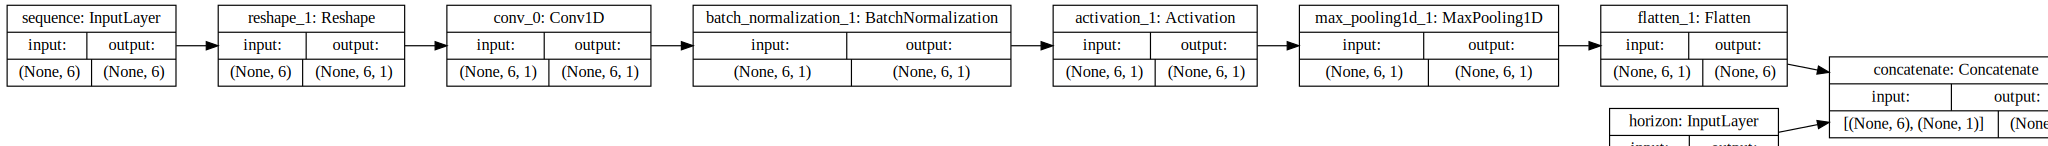

In [0]:
vis_model(multinetwork.model["forecast"], show_shapes=True, rankdir="LR")

### Connect feature pipelines to the neural network

In [0]:
from timeserio.pipeline import MultiPipeline

In [0]:
multipipeline = MultiPipeline({
    "sequence": seq_pipeline,
    "horizon": fc_horizon_pipeline,
    "target": target_pipeline
})

In [0]:
from timeserio.multimodel import MultiModel

manifold = {
    # keras_model_name: (input_pipes, output_pipes)
    "encoder": ("sequence", None),
    "forecast": (["sequence", "horizon"], "target")
}

multimodel = MultiModel(
    multinetwork=multinetwork,
    multipipeline=multipipeline,
    manifold=manifold
)

### Fit model from the batch generator

`multimodel.fit_generator()` will apply pipelines correctly to the training batch generator, and, if `validation_data` is provided in the form of another (pandas) batch generator,
evaluate the relevant metrics. In addition, feature extraction for each batch will benefit from the `workers` parallelism.

In [0]:
!pip install kerashistoryplot

### Rolling Generator

In [0]:
import numpy as np
import pandas as pd
import pytest

import timeserio.ini as ini
from timeserio.data.mock import mock_fit_data, mock_raw_data
from timeserio.batches.single.sequence import (
    SamplingForecastBatchGenerator, SequenceForecastBatchGenerator, ForecastBatchGeneratorBase, BatchGenerator
)
from numpy.testing import assert_array_equal

In [0]:
import abc
import functools
from typing import Union

import numpy as np

from  timeserio import ini
from timeserio.preprocessing.pandas import array_to_dataframe
from timeserio.batches.utils import ceiling_division

In [0]:
class RollingSequenceBatchGenerator(BatchGenerator):
   """Generate batches of sequence forecast examples.
   Assume single continuous timeseries.
   """
   def __init__(
       self,
       *,
       df,
       batch_size: Union[None, int] = None,
 
       lookback_steps=2, # The steps of look back (history)
       lookback_columns=[ini.Columns.datetime, ini.Columns.target],
       lookback_prefix='back_',
       
       forecast_steps=1,  # The steps of forecasting
       forecast_columns=[ini.Columns.target],
       forecast_prefix='fore_',
              
       id_column=None,
       last_step_columns=[ini.Columns.datetime],
       last_step_prefix='end_of_',
       dt_column=ini.Columns.datetime,
       start_time=None
   ):
       self.df = df
       self.batch_size = batch_size
       self.lookback_steps = lookback_steps
       self.lookback_columns = lookback_columns
       self.lookback_prefix = lookback_prefix
 
       self.forecast_steps = forecast_steps
       self.forecast_columns = forecast_columns
       self.forecast_prefix = forecast_prefix
              
       self.last_step_columns = last_step_columns
       self.last_step_prefix = last_step_prefix
 
       if lookback_columns:
           if not lookback_prefix:
               raise ValueError('`lookback_prefix` must be non-empty')
 
       if last_step_columns:
           if not (set(last_step_columns) <= set(lookback_columns)):
               raise ValueError('`last_step_columns` must be a subset of '
                                '`lookback_columns`')
       if not forecast_columns:
           raise ValueError('`forecast_columns` must be non-empty')
 
       if not (set(forecast_columns) <= set(lookback_columns)):
           raise ValueError('`forecast_columns` must be a subset of '
                                '`lookback_columns`')
       if not last_step_prefix:
           raise ValueError('`last_step_prefix` must be non-empty')
      
       if last_step_prefix == lookback_prefix:
            raise ValueError('`last_step_prefix` must be '
                            'different from `lookback_prefix`')

       self.dt_column = dt_column
       self.start_time = start_time
 
   @property
   def num_points(self):
       """Return number of rows in original timeseries."""
       return len(self.df)
 
   @property  # type: ignore
   @functools.lru_cache(None)
   def first_index(self):
       if self.start_time is None:
           return 0
       times = self.df[self.dt_column].dt.time.values
       first_idx = np.argmax(times == self.start_time)
       if not first_idx and times[0] != self.start_time:
           raise ValueError(f'Start time {self.start_time} not found in df')
       return first_idx
 
   @property
   def num_examples(self):
       """Return number of examples to yield in one epoch."""
       return max(0,self.num_points-self.lookback_steps - self.forecast_steps -self.first_index+1)
      
   @property
   def _eff_batch_size(self):
       return self.batch_size or self.num_examples
 
   def __len__(self):
       return ceiling_division(self.num_examples, self._eff_batch_size)
 
   def batch_seq_start_indices(self, batch_idx):
       start_indices = np.arange(
           self._eff_batch_size * batch_idx,
           min(self._eff_batch_size * (batch_idx + 1), self.num_examples)
       )
       return self.first_index + start_indices
 
   def _get_lookback_values(self, column, start_indices):
       values = self.df[column].values
       cols = [
           values[start_indices + s] for s in range(self.lookback_steps)
       ]
       seq_values = np.vstack(cols).T
       return seq_values
      
   def _get_forecast_values(self, column, start_indices):
       values = self.df[column].values
       cols = [
           values[start_indices + self.lookback_steps + s ] for s in range(self.forecast_steps)
       ]
       seq_values = np.vstack(cols).T
       return seq_values
 
   def __getitem__(self, batch_idx):
       if not len(self):
           raise IndexError('Batch index out of range: Empty batch generator')
       batch_idx = batch_idx % len(self)
       start_indices = self.batch_seq_start_indices(batch_idx)
       batch_size = len(start_indices)
       end_indices = start_indices + self.lookback_steps
       fc_indices = end_indices
       cols = []
       lookback_columns = self.lookback_columns or []
       forecast_columns = self.forecast_columns or []
       last_step_columns = self.last_step_columns or []
 
       cols = cols + lookback_columns
       batch_df = self.df[cols].iloc[fc_indices].copy()
       batch_df.reset_index(drop=True, inplace=True)
       for column in lookback_columns:
           seq_values = self._get_lookback_values(
               column, start_indices
           )
           seq_col_name = self.lookback_prefix + column
           batch_df = array_to_dataframe(
               seq_values,
               column=seq_col_name,
               df=batch_df
           )

       #if forecast_steps>1: 
       for column in forecast_columns:
           seq_values = self._get_forecast_values(
               column, start_indices
           )
           seq_col_name = self.forecast_prefix + column
           batch_df = array_to_dataframe(
               seq_values,
               column=seq_col_name,
               df=batch_df
           )

       for column in last_step_columns:
           seq_col_name = self.lookback_prefix + column
           last_step_col_name = self.last_step_prefix + column
           batch_df[last_step_col_name] = batch_df[seq_col_name].iloc[:, -1]
 
       return batch_df


In [0]:
"""Generate batches from pandas DataFrame."""
from typing import Union

from timeserio.batches.chunked.base import ChunkedBatchGenerator
from timeserio import ini

single_sequence= RollingSequenceBatchGenerator

In [0]:
class RollingForecastBatchGeneratorChunked(ChunkedBatchGenerator):
    def __init__(
        self,
        *,
        df,
        batch_size: Union[None, int] = None,

        lookback_steps=2, # The steps of look back (history)
        lookback_columns=[ini.Columns.datetime, ini.Columns.target],
        lookback_prefix='back_',
        
        forecast_steps=1,  # The steps of forecasting
        forecast_columns=[ini.Columns.target],
        forecast_prefix='fore_',
                
        id_column=None,
        last_step_columns=[ini.Columns.datetime],
        last_step_prefix='end_of_',
        dt_column=ini.Columns.datetime,
        start_time=None,

        batch_aggregator=1
    ):
        super().__init__()

        self.df = df
        self.batch_size = batch_size
        self.lookback_steps = lookback_steps
        self.lookback_columns = lookback_columns
        self.lookback_prefix = lookback_prefix
  
        self.forecast_steps = forecast_steps
        self.forecast_columns = forecast_columns
        self.forecast_prefix = forecast_prefix
                
        self.last_step_columns = last_step_columns
        self.last_step_prefix = last_step_prefix
  
        if lookback_columns:
            if not lookback_prefix:
                raise ValueError('`lookback_prefix` must be non-empty')
  
        if last_step_columns:
            if not (set(last_step_columns) <= set(lookback_columns)):
                raise ValueError('`last_step_columns` must be a subset of '
                                  '`lookback_columns`')
        if not forecast_columns:
            raise ValueError('`forecast_columns` must be non-empty')
  
        if not (set(forecast_columns) <= set(lookback_columns)):
            raise ValueError('`forecast_columns` must be a subset of '
                                  '`lookback_columns`')
        if not last_step_prefix:
            raise ValueError('`last_step_prefix` must be non-empty')
        
        if last_step_prefix == lookback_prefix:
              raise ValueError('`last_step_prefix` must be '
                              'different from `lookback_prefix`')

        self.id_column = id_column
        self.dt_column = dt_column
        self.start_time = start_time
       
        self.subgens = []  # type: ignore
        self.batch_aggregator = batch_aggregator
        self.unique_ids = self.df[self.id_column].unique()

    @property
    def chunks(self):
        return self.unique_ids

    def make_subgen(self, chunk):
        cust_id = chunk
        subgen = single_sequence(
            df=self.df[self.df[self.id_column] == cust_id],
            batch_size=self.batch_size,
            id_column=self.id_column,
            
            last_step_columns=self.last_step_columns,
            last_step_prefix=self.last_step_prefix,
            
            dt_column=self.dt_column,
            start_time=self.start_time,
 
            lookback_steps=self.lookback_steps, # The steps of look back (history)
            lookback_columns=self.lookback_columns,
            lookback_prefix=self.lookback_prefix,
            
            forecast_steps=self.forecast_steps,  # The steps of forecasting
            forecast_columns=self.forecast_columns,
            forecast_prefix=self.forecast_prefix
        )
        return subgen

### Rolling Generator declare

In [0]:
rolling_chunked=RollingForecastBatchGeneratorChunked(
    df=df_train,id_column="country",lookback_steps=6,forecast_steps=2,lookback_columns=["generation", "Time_step"],
    forecast_columns=["generation"],
     last_step_columns=["Time_step"] ,batch_size=2**15,
     )

In [0]:
rolling_chunked.chunks

array(['UK', 'ES'], dtype=object)

In [0]:
sub0=rolling_chunked.make_subgen('UK')
sub0[0]

generation Time_step  ... fore_generation end_of_Time_step
                            ...               1                 
0       0.000000         7  ...        0.000000                6
1       0.000000         8  ...        0.000000                7
2       0.000000         9  ...        0.047485                8
3       0.047485        10  ...        0.109517                9
4       0.109517        11  ...        0.164216               10
...          ...       ...  ...             ...              ...
32763   0.121928     32770  ...        0.147955            32769
32764   0.147955     32771  ...        0.163166            32770
32765   0.163166     32772  ...        0.129599            32771
32766   0.129599     32773  ...        0.122734            32772
32767   0.122734     32774  ...        0.097022            32773

[32768 rows x 17 columns]

In [0]:
from kerashistoryplot.callbacks import PlotHistory
#plot_callback = PlotHistory(figsize=(15, 3), n_cols=3, batches=False)

multimodel.fit_generator(
    rolling_chunked, model="forecast", verbose=1, epochs=10,
    reset_weights=True,
    workers=4
    #, callbacks=[plot_callback]
)



Epoch 1/10
16/16 [==============================] - 2s 113ms/step - loss: 0.0366 - mean_absolute_error: 0.1092
Epoch 2/10
16/16 [==============================] - 2s 101ms/step - loss: 0.0242 - mean_absolute_error: 0.1002
Epoch 3/10
16/16 [==============================] - 2s 97ms/step - loss: 0.0187 - mean_absolute_error: 0.0921
Epoch 4/10
16/16 [==============================] - 2s 102ms/step - loss: 0.0152 - mean_absolute_error: 0.0834
Epoch 5/10
16/16 [==============================] - 2s 99ms/step - loss: 0.0130 - mean_absolute_error: 0.0779
Epoch 6/10
16/16 [==============================] - 2s 104ms/step - loss: 0.0116 - mean_absolute_error: 0.0739
Epoch 7/10
16/16 [==============================] - 1s 92ms/step - loss: 0.0103 - mean_absolute_error: 0.0699
Epoch 8/10
16/16 [==============================] - 2s 100ms/step - loss: 0.0094 - mean_absolute_error: 0.0665
Epoch 9/10
16/16 [==============================] - 2s 106ms/step - loss: 0.0087 - mean_absolute_error: 0.0642
Ep

persist the model:

In [0]:
model_file="/tmp/model.pickle"
network_file="/tmp/network.pickle"
weights_file="/tmp/weights.pickle"

In [0]:
from timeserio.utils.pickle import loadf, dumpf
dumpf(multimodel, model_file)
dumpf(multinetwork, network_file)
dumpf(multinetwork.weights, weights_file)

In [0]:
from google.colab import files
files.download(model_file)
files.download(network_file)
files.download(weights_file)

In [0]:
multimodel.multinetwork.weights

{'encoder': [array([[[0.24813499]]], dtype=float32),
  array([0.00163302], dtype=float32),
  array([1.0501057], dtype=float32),
  array([0.11739083], dtype=float32),
  array([0.03460965], dtype=float32),
  array([0.00223897], dtype=float32)],
 'forecast': [array([[[0.24813499]]], dtype=float32),
  array([0.00163302], dtype=float32),
  array([1.0501057], dtype=float32),
  array([0.11739083], dtype=float32),
  array([0.03460965], dtype=float32),
  array([0.00223897], dtype=float32),
  array([[ 0.2842112 , -0.5701866 ,  0.12303936, -0.31303486,  0.34182647,
           0.22236133,  0.4843851 , -0.03378399],
         [-0.24248841,  0.54876417,  0.59752405, -0.23054275, -0.0557189 ,
           0.27279264,  0.42946422, -0.5015413 ],
         [ 0.38957378, -0.09641979,  0.24506073, -0.28375766, -0.49676055,
           0.41025755, -0.2153305 ,  0.41597456],
         [ 0.627032  , -0.4362499 , -0.56706876, -0.45808616, -0.12986566,
           0.09596018, -0.01438249,  0.5095536 ],
         [ 0.1

### Evaluate performance on test data
We can evaluate the model on the validation data generator, which can also be out-of-memory:

In [0]:
rolling_chunked_test=RollingForecastBatchGeneratorChunked(
    df=df_test,id_column="country",lookback_steps=6,forecast_steps=2,lookback_columns=["generation", "Time_step"],
    forecast_columns=["generation", "Time_step"],
     last_step_columns=["Time_step"],batch_size=2**15,
     )

In [0]:
multimodel.evaluate_generator(rolling_chunked_test, model="forecast", verbose=1)

2/2 [==============================] - 0s 60ms/step


[0.006176444236189127, 0.053669482469558716]

While the model takes longer to train (and longer still with practical encoder architectures), it can be tuned to achieve higher performanec, especially if encodings are combined with datetime features.

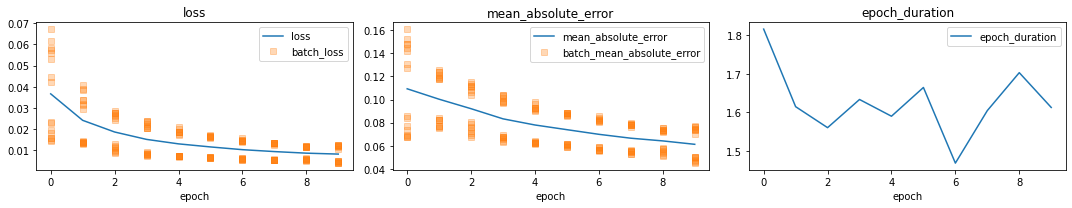

In [0]:
from kerashistoryplot.plot import plot_history
history = multimodel.history[-1]["history"]
plot_history(history, figsize=(15, 3), n_cols=3);